In [1]:
#%matplotlib ipympl

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import sys
from datetime import datetime
import logging
import json
import os

sys.path.append('/home/bart/meteo/models/LS2D')
import ls2d
ls2d.logger.logger.setLevel(logging.INFO)       # FIX IMPORT PATH IN LS2D!

"""
Global settings
"""
ls2d_data_path = '/home/scratch1/bart/LS2D_EWED'

In [2]:
"""
Help code to deal with mixed-layer profiles in dict/JSON structures.
"""

def get_mxl_dict():
    """
    Create dictionary with all mixed-layer properties:
    Initial profiles, forcings, surface fluxes, ...
    Initial values are completely (well, almost) random.
    """
    return dict(
        zi = 500,
        thl = 290,
        dthl = 2,
        gamma_thl_1 = 0.003,
        z1_thl = 1500,
        gamma_thl_2 = 0.006,
        qt = 10e-3,
        dqt = -2e-3,
        gamma_qt_1 = -0.002e-3,
        z1_qt = 1200,
        gamma_qt_2 = -0.003e-3,
        div = 1e-5,
        u = 5,
        ug = 7,
        du = 2,
        gamma_u_1 = 1e-3,
        z1_u = 1200,
        gamma_u_2 = 1e-3,
        v = 5,
        vg = 6,
        dv = 1,
        gamma_v_1 = -1e-3,
        z1_v = 1200,
        gamma_v_2 = -1e-3,
        start_time = datetime(1900,1,1).isoformat(),
        time = [0],
        wthl = [0],
        wqt = [0],
        is_tuned = False
    )


def load_json(json_file):
    """
    Load `json_file` from disk into dict.
    """
    with open(json_file, 'r', encoding='utf-8') as f:
        return json.load(f)


def save_json(data, json_file):
    """
    Save `data` to `json_file`.
    """
    with open(json_file, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

In [3]:
"""
Interactive / dragable mixed-layer profile.
"""

class Mixed_layer_profile:
    def __init__(self, fig, ax, x, y, instances):
        self.fig = fig
        self.ax = ax
        self.x = np.array(x, dtype=np.float32)
        self.y = np.array(y, dtype=np.float32)
        self.instances = instances
        
        self.points, = ax.plot(self.x, self.y, 'o', color='b', mfc='none', picker=True, pickradius=5)
        self.line,   = ax.plot(self.x, self.y, 'b--')

        self.labels = ['bulk', 'jump', 'zi', 'z1', 'gamma1', 'gamma2']
        self.texts = []
        for label in self.labels:
            x, y, text, ha, va = self.get_label(label)
            self.texts.append(plt.text(x, y, text, ha=ha, va=va))

        self.index = None

        self.cid_press = fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.cid_release = fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.cid_motion = fig.canvas.mpl_connect('motion_notify_event', self.on_motion)


    def get_label(self, name):
        """
        Get label incl. coordinates and alignments.
        """

        x_margin = 0.04 * (self.x.max() - self.x.min())
        y_margin = 0.02 * (self.y.max() - self.y.min())

        sign = +1 if self.x[2] > self.x[1] else -1

        if name == 'bulk':
            x = self.x[0] + x_margin
            y = 0.5 * (self.y[0] + self.y[1])
            text = f'<φ>={self.x[0]:.1f}'
            ha = 'left'
            va = 'center'
        
        elif name == 'zi':
            x = self.x[0] - sign * x_margin
            y = self.y[1]
            text = rf'$z_i$={self.y[1]:.0f}'
            ha = 'right' if sign > 0 else 'left'
            va = 'center'

        elif name == 'jump':
            x = 0.5 * (self.x[1] + self.x[2])
            y = self.y[1] + y_margin
            text = f'Δ={self.x[2]-self.x[1]:.1f}'
            ha = 'center'
            va = 'bottom'

        elif name == 'z1':
            x = self.x[3] + x_margin
            y = self.y[3]
            text = rf'$z_1$={self.y[3]:.0f}'
            ha = 'left'
            va = 'center'

        elif name == 'gamma1':
            x = 0.5 * (self.x[2] + self.x[3]) + x_margin
            y = 0.5 * (self.y[2] + self.y[3])
            text = rf'$γ_1$={(self.x[3] - self.x[2])/(self.y[3] - self.y[2]) * 1000:.1f}'
            ha = 'left'
            va = 'center'

        elif name == 'gamma2':
            x = 0.5 * (self.x[3] + self.x[4]) + x_margin
            y = 0.5 * (self.y[3] + self.y[4])
            text = rf'$γ_2$={(self.x[4] - self.x[3])/(self.y[4] - self.y[3]) * 1000:.1f}'
            ha = 'left'
            va = 'center'

        return x, y, text, ha, va


    def on_press(self, event):

        if event.inaxes != self.ax:
            return

        x_lim = self.ax.get_xlim()
        y_lim = self.ax.get_ylim()

        x_range = x_lim[1] - x_lim[0]
        y_range = y_lim[1] - y_lim[0]

        x_norm = (self.x - x_lim[0]) / x_range
        y_norm = (self.y - y_lim[0]) / y_range
    
        event_x_norm = (event.xdata - x_lim[0]) / x_range
        event_y_norm = (event.ydata - y_lim[0]) / y_range

        distances = np.hypot(x_norm - event_x_norm, y_norm - event_y_norm)
    
        closest_index = np.argmin(distances)
        if distances[closest_index] < 0.05:
            self.index = closest_index


    def on_release(self, event):
        self.index = None


    def on_motion(self, event):
        if self.index is None or event.inaxes != self.ax:
            return

        # Some limits for mixed-layer shaped profile.
        # 1. Mixed-layer should stay mixed.
        if self.index == 0 or self.index == 1:
            self.x[0] = event.xdata
            self.x[1] = event.xdata

            self.y[self.index] = event.ydata

        # 2. Inversion should stay level.
        if self.index == 1 or self.index == 2:

            # Update height in all `Mixed_layer_profile` instances.
            for instance in self.instances:
                
                if instance == self:
                    instance.x[self.index] = event.xdata

                instance.y[1] = event.ydata
                instance.y[2] = event.ydata
        
        # Only update value, not height, for topmost point.
        if self.index == 4:
            self.x[self.index] = event.xdata

        # 3. Other points are free.
        elif self.index > 2:
            self.x[self.index] = event.xdata
            self.y[self.index] = event.ydata

        # 4. Make sure first point stays at z=0.
        if self.index == 0:
            self.y[0] = 0.

        # Update all profiles, including sister ones.
        for instance in self.instances:
            instance.update_plot()
    

    def update_plot(self):

        self.points.set_data(self.x, self.y)
        self.line.set_data(self.x, self.y)

        # Update all texts.
        for i, label in enumerate(self.labels):
            x, y, text, _, _ = self.get_label(label)
            self.texts[i].set_position((x, y))
            self.texts[i].set_text(text)

        #self.fig.canvas.blit(self.ax.bbox)  # Faster rendering
        #self.fig.canvas.draw()
        self.fig.canvas.draw_idle()


class Subsidence_profile:
    def __init__(self, fig, ax, div_U):
        self.fig = fig
        self.ax = ax

        self.div_U = div_U

        self.y = np.array([0, 4000], dtype=np.float32)
        self.x = (-div_U * self.y).astype(np.float32)
        
        self.points, = ax.plot(self.x, self.y, 'o', color='b', mfc='none', picker=True, pickradius=5)
        self.line,   = ax.plot(self.x, self.y, 'b--')

        x_margin = 0.04 * (self.x.max() - self.x.min())
        self.text = plt.text(self.x.mean()+x_margin, self.y.mean(), rf'div(U)={self.div_U:.1e}', ha='left', va='center')

        self.index = None

        self.cid_press = fig.canvas.mpl_connect('button_press_event', self.on_press)
        self.cid_release = fig.canvas.mpl_connect('button_release_event', self.on_release)
        self.cid_motion = fig.canvas.mpl_connect('motion_notify_event', self.on_motion)


    def on_press(self, event):

        if event.inaxes != self.ax:
            return

        self.index = 1


    def on_release(self, event):
        self.index = None


    def on_motion(self, event):

        if self.index is None or event.inaxes != self.ax:
            return

        self.x[1] = event.xdata

        self.points.set_data(self.x, self.y)
        self.line.set_data(self.x, self.y)

        self.div_U = -self.x[1] / self.y[1]

        x_margin = 0.04 * (self.x.max() - self.x.min())
        self.text.set_position((self.x.mean()+x_margin, self.y.mean()))
        self.text.set_text(rf'div(U)={self.div_U:.1e}')

        #self.fig.canvas.blit(self.ax.bbox)  # Faster rendering
        #self.fig.canvas.draw()
        self.fig.canvas.draw_idle()


In [4]:
"""
Class to download / parse a single wild fire case.
"""

class Fire_case:
    def __init__(self, name, lon, lat, start, end):
        self.name = name

        self.lon = lon
        self.lat = lat

        self.start = datetime.fromisoformat(start)
        self.end = datetime.fromisoformat(end)

        self.ls2d_settings = {
            'central_lat' : self.lat,
            'central_lon' : self.lon,
            'area_size'   : 1,
            'case_name'   : self.name,
            'era5_path'   : ls2d_data_path,
            'era5_expver' : 1,
            'start_date'  : self.start,
            'end_date'    : self.end,
            'write_log'   : False,
            'data_source' : 'CDS'}

        # Read or create dictionary with mixed-layer structure.
        self.json_file = f'{name}.json'

        if os.path.exists(self.json_file):
            print(f'Found tuned case for \"{name}\", loading...')
            self.mxl = load_json(self.json_file)
        else:
            print(f'No tuning for \"{name}\", creating new one...')
            self.mxl = get_mxl_dict()


    def download(self):
        """
        Download required ERA5 data using (LS)2D.
        """
        ls2d.download_era5(self.ls2d_settings, exit_when_waiting=False)


    def read(self):
        """
        Read ERA5 data with (LS)2D, and calculate large-scale forcings.
        """
        _era5 = ls2d.Read_era5(self.ls2d_settings)
        _era5.calculate_forcings(n_av=1, method='2nd')

        # Interpolate ERA5 to fixed height grid:
        self.z = np.arange(10., 4000., 20.)
        self.era5 = _era5.get_les_input(self.z)

        # Remove negative surface fluxes.
        # Does not work in a mixed-layer model, as this results in negative BL growth.
        self.era5.wth[self.era5.wth < 0] = 0
        self.era5.wq [self.era5.wq  < 0] = 0


    def plot(self):
        """
        Plot ERA5 initial profiles.
        """

        def get_range(time_prof):
            min_val = np.min(time_prof, axis=0)
            max_val = np.max(time_prof, axis=0)
            mean_val = np.mean(time_prof, axis=0)
            return min_val, mean_val, max_val

        def fmt_time():
            ax = plt.gca()
            hh = mdates.HourLocator(interval=3)
            fmt = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_locator(hh)
            ax.xaxis.set_major_formatter(fmt)

        # For new input, guess mixed-layer values.
        if not self.mxl['is_tuned']:

            self.mxl['thl'] = self.era5.thl[0,:10].mean()
            self.mxl['qt']  = self.era5.qt[0,:10].mean()

            self.mxl['u'] = self.era5.u[0,:10].mean()
            self.mxl['v']  = self.era5.v[0,:10].mean()

        def get_mxl_prof(var):
            """
            Create mixed-layer profile.
            """
            z0 = self.mxl['zi']
            z1 = self.mxl[f'z1_{var}']
            z2 = 4000

            v0 = self.mxl[f'{var}']
            v1 = v0 + self.mxl[f'd{var}']
            v2 = v1 + (z1-z0) * self.mxl[f'gamma_{var}_1']
            v3 = v2 + (z2-z1) * self.mxl[f'gamma_{var}_2']

            z = np.array([0, z0, z0, z1, z2])
            p = np.array([v0, v0, v1, v2, v3])

            if var == 'qt':
                p *= 1000.

            return z, p

        z_thl, p_thl = get_mxl_prof('thl')
        z_qt, p_qt = get_mxl_prof('qt')
        z_u, p_u = get_mxl_prof('u')
        z_v, p_v = get_mxl_prof('v')

        self.mxl_profs = []

        fig=plt.figure(figsize=(10,8), layout='tight')
        plt.suptitle(rf'$\bf{{{self.name}}}$ ({self.lon}$^o$E, {self.lat}$^o$N): {self.start}')

        ax=plt.subplot(231)
        plt.plot(self.era5.thl[0,:], self.era5.z, label='ERA5')
        self.mxl_thl = Mixed_layer_profile(fig, ax, p_thl, z_thl, self.mxl_profs)
        plt.xlabel(r'$\theta_\mathrm{l}$ (K)')
        plt.ylabel(r'$z$ (m)')
        plt.legend()

        ax=plt.subplot(232)
        plt.plot(self.era5.qt[0,:]*1e3, self.era5.z)
        self.mxl_qt = Mixed_layer_profile(fig, ax, p_qt, z_qt, self.mxl_profs)
        plt.xlabel(r'$q_\mathrm{t}$ (g kg$^{-1}$)')

        ax=plt.subplot(233)
        plt.plot(self.era5.time, self.era5.wth*1.2*1005, color='r', label=r'H')
        plt.plot(self.era5.time, self.era5.wq*1.2*2.5e6, color='b', label=r'LE')
        plt.xlabel(r'time (UTC)')
        plt.ylabel(r'Flux (W m$^{-2}$)')
        plt.legend()
        fmt_time()

        ax=plt.subplot(234)
        plt.plot(self.era5.u[0,:], self.era5.z, label=r'$u$')

        min_ug, mean_ug, max_ug = get_range(self.era5.ug)
        plt.fill_betweenx(self.era5.z, min_ug, max_ug, alpha=0.1)
        plt.plot(mean_ug, self.era5.z, ':', color='C0', label=r'$u_\mathrm{g}$')

        self.mxl_u = Mixed_layer_profile(fig, ax, p_u, z_u, self.mxl_profs)
        plt.xlabel(r'$u$ (m s$^{-1}$)')
        plt.ylabel(r'$z$ (m)')
        plt.legend()

        ax=plt.subplot(235)
        plt.plot(self.era5.v[0,:], self.era5.z, label=r'$v$')

        min_vg, mean_vg, max_vg = get_range(self.era5.vg)
        plt.fill_betweenx(self.era5.z, min_vg, max_vg, alpha=0.1)
        plt.plot(mean_vg, self.era5.z, ':', color='C0', label=r'$v_\mathrm{g}$')

        self.mxl_v = Mixed_layer_profile(fig, ax, p_v, z_v, self.mxl_profs)
        plt.xlabel(r'$v$ (m s$^{-1}$)')
        plt.legend()

        ax=plt.subplot(236)

        min_wls, mean_wls, max_wls = get_range(self.era5.wls)
        plt.fill_betweenx(self.era5.z, min_wls, max_wls, alpha=0.1)
        plt.plot(mean_wls, self.era5.z, ':', color='C0')

        self.mxl_wls = Subsidence_profile(fig, ax, self.mxl['div'])

        plt.xlabel(r'$w_\mathrm{LS}$ (m s$^{-1}$)')

        # Keep track of all mixed-layer profiles. We need to 
        # update the boundary layer height in all plots.
        self.mxl_profs.append(self.mxl_thl) 
        self.mxl_profs.append(self.mxl_qt) 
        self.mxl_profs.append(self.mxl_u) 
        self.mxl_profs.append(self.mxl_v) 


    def save_mxl_params(self):
        """
        Save mixed-layer parameters to JSON after tuning."
        """ 

        # Get profiles from plotting instance.
        thl = self.mxl_thl.x
        z_thl = self.mxl_thl.y

        qt  = self.mxl_qt.x / 1000.
        z_qt  = self.mxl_qt.y

        u = self.mxl_u.x
        z_u = self.mxl_u.y

        v = self.mxl_v.x
        z_v = self.mxl_v.y

        # Store parameters.
        self.mxl['zi'] = float(z_thl[1])

        self.mxl['thl'] = float(thl[0])
        self.mxl['dthl'] = float(thl[2] - thl[1])
        self.mxl['gamma_thl_1'] = float((thl[3] - thl[2]) / (z_thl[3] - z_thl[2]))
        self.mxl['z1_thl'] = float(z_thl[3])
        self.mxl['gamma_thl_2'] = float((thl[4] - thl[3]) / (z_thl[4] - z_thl[3]))

        self.mxl['qt'] = float(qt[0])
        self.mxl['dqt'] = float(qt[2] - qt[1])
        self.mxl['gamma_qt_1'] = float((qt[3] - qt[2]) / (z_qt[3] - z_qt[2]))
        self.mxl['z1_qt'] = float(z_qt[3])
        self.mxl['gamma_qt_2'] = float((qt[4] - qt[3]) / (z_qt[4] - z_qt[3]))

        self.mxl['u'] = float(u[0])
        self.mxl['du'] = float(u[2] - u[1])
        self.mxl['gamma_u_1'] = float((u[3] - u[2]) / (z_u[3] - z_u[2]))
        self.mxl['z1_u'] = float(z_u[3])
        self.mxl['gamma_u_2'] = float((u[4] - u[3]) / (z_u[4] - z_u[3]))

        self.mxl['v'] = float(v[0])
        self.mxl['dv'] = float(v[2] - v[1])
        self.mxl['gamma_v_1'] = float((v[3] - v[2]) / (z_v[3] - z_v[2]))
        self.mxl['z1_v'] = float(z_v[3])
        self.mxl['gamma_v_2'] = float((v[4] - v[3]) / (z_v[4] - z_v[3]))

        self.mxl['div'] = float(-self.mxl_wls.x[1] / self.mxl_wls.y[1])

        self.mxl['start_time'] = self.start.isoformat()

        self.mxl['time'] = [int(x) for x in np.arange(self.era5.time.size)]
        self.mxl['wthl'] = [float(x) for x in self.era5.wth]
        self.mxl['wqt'] = [float(x) for x in self.era5.wq]

        self.mxl['is_tuned'] = True

        # Save in JSON format.
        save_json(self.mxl, self.json_file)

In [5]:
"""
Different cases from EWED platform.
Currently incomplete, the website has some inconsistencies in the dates...
"""
# NOTE: start times are rounded down to the nearest full hour for (LS)2D.

cases = {}
cases['tortosa'] = Fire_case(name='tortosa', lon=0.593460, lat=40.823570, start='2024-05-28T08:00:00', end='2024-05-28T23:00:00')
cases['katsimidi'] = Fire_case(name='katsimidi', lon=23.791808, lat=38.183321, start='2024-06-29T11:00:00', end='2024-06-29T23:00:00')
cases['mequinensa'] = Fire_case(name='mequinensa', lon=0.315670, lat=41.379853, start='2024-07-07T15:00:00', end='2024-07-07T23:00:00')
cases['vilanova-da-meia'] = Fire_case(name='vilanova-da-meia', lon=1.072223, lat=41.947036, start='2024-08-09T13:00:00', end='2024-08-09T23:00:00')
cases['varnavas'] = Fire_case(name='varnavas', lon=23.924421, lat=38.237959, start='2024-08-11T12:00:00', end='2024-08-11T23:00:00')
cases['la-figuera'] = Fire_case(name='la-figuera', lon=0.741027, lat=41.214060, start='2024-07-28T13:00:00', end='2024-07-28T23:00:00')
cases['orista'] = Fire_case(name='orista', lon=2.052567, lat=41.902943, start='2023-10-05T10:00:00', end='2023-10-05T23:00:00')
cases['pont-de-vilomara'] = Fire_case(name='pont-de-vilomara', lon=1.901683, lat=41.686460, start='2022-07-07T11:00:00', end='2022-07-07T23:00:00')

for name, case in cases.items():
    case.download()
    case.read()

[2025/04/01 15:11:03] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-05-28 08:00:00 to 2024-05-28 23:00:00'
[2025/04/01 15:11:03] [(LS)²D] [INFO] Reading ERA5 from 2024-05-28 08:00:00 to 2024-05-28 23:00:00'


Found tuned case for "tortosa", loading...
Found tuned case for "katsimidi", loading...
Found tuned case for "mequinensa", loading...
Found tuned case for "vilanova-da-meia", loading...
Found tuned case for "varnavas", loading...
Found tuned case for "la-figuera", loading...
Found tuned case for "orista", loading...
Found tuned case for "pont-de-vilomara", loading...


[2025/04/01 15:11:03] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-06-29 11:00:00 to 2024-06-29 23:00:00'
[2025/04/01 15:11:03] [(LS)²D] [INFO] Reading ERA5 from 2024-06-29 11:00:00 to 2024-06-29 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-07-07 15:00:00 to 2024-07-07 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Reading ERA5 from 2024-07-07 15:00:00 to 2024-07-07 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-08-09 13:00:00 to 2024-08-09 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Reading ERA5 from 2024-08-09 13:00:00 to 2024-08-09 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-08-11 12:00:00 to 2024-08-11 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Reading ERA5 from 2024-08-11 12:00:00 to 2024-08-11 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Downloading ERA5 for period: 2024-07-28 13:00:00 to 2024-07-28 23:00:00'
[2025/04/01 15:11:04] [(LS)²D] [INFO] Reading

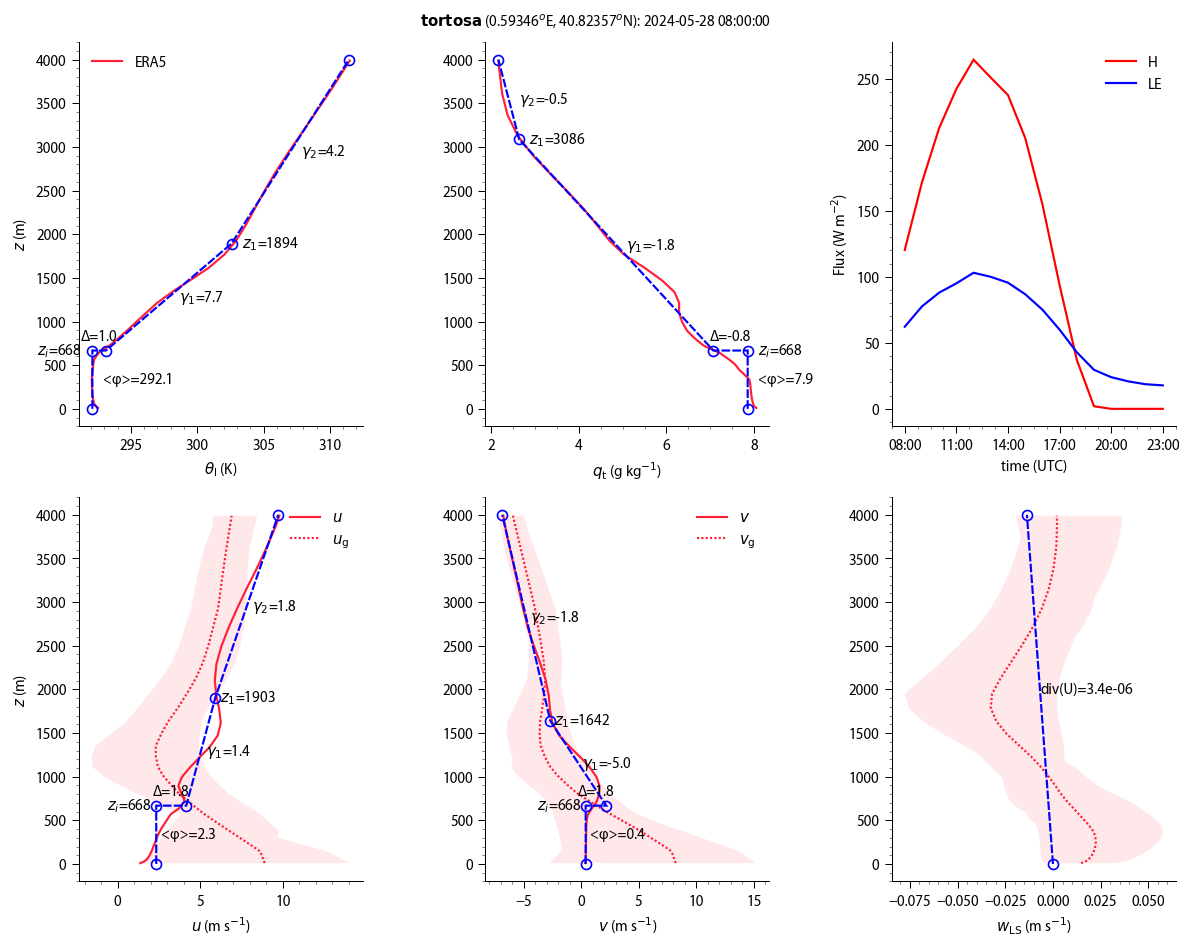

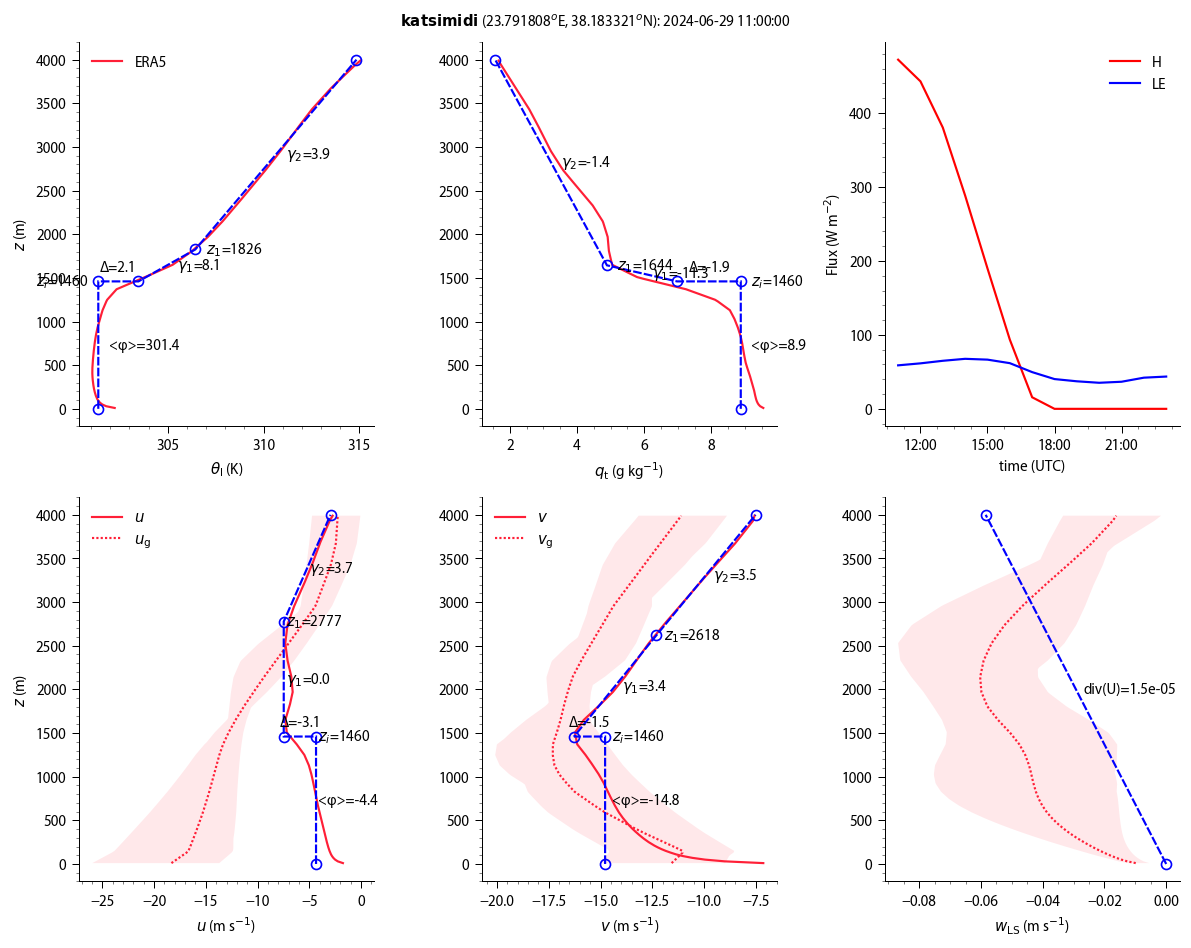

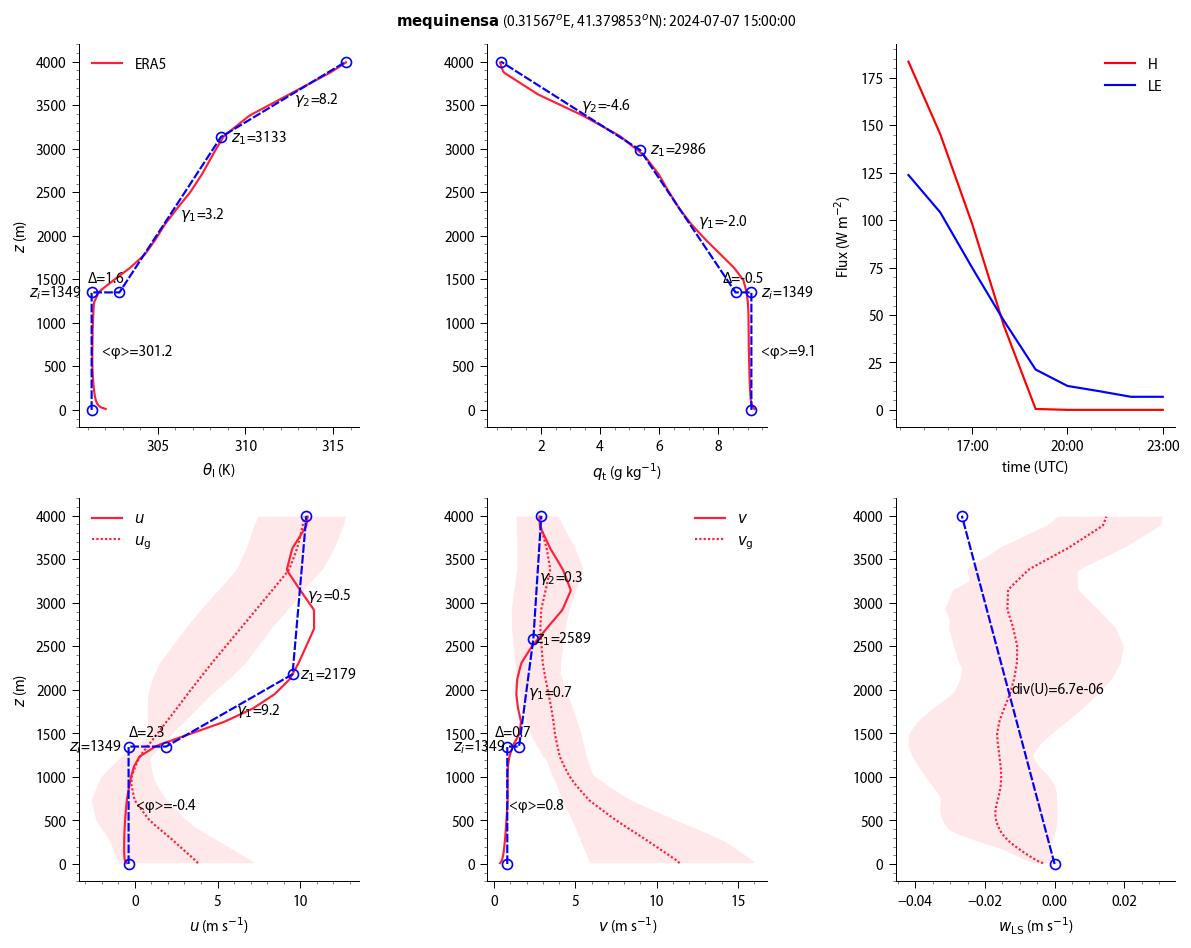

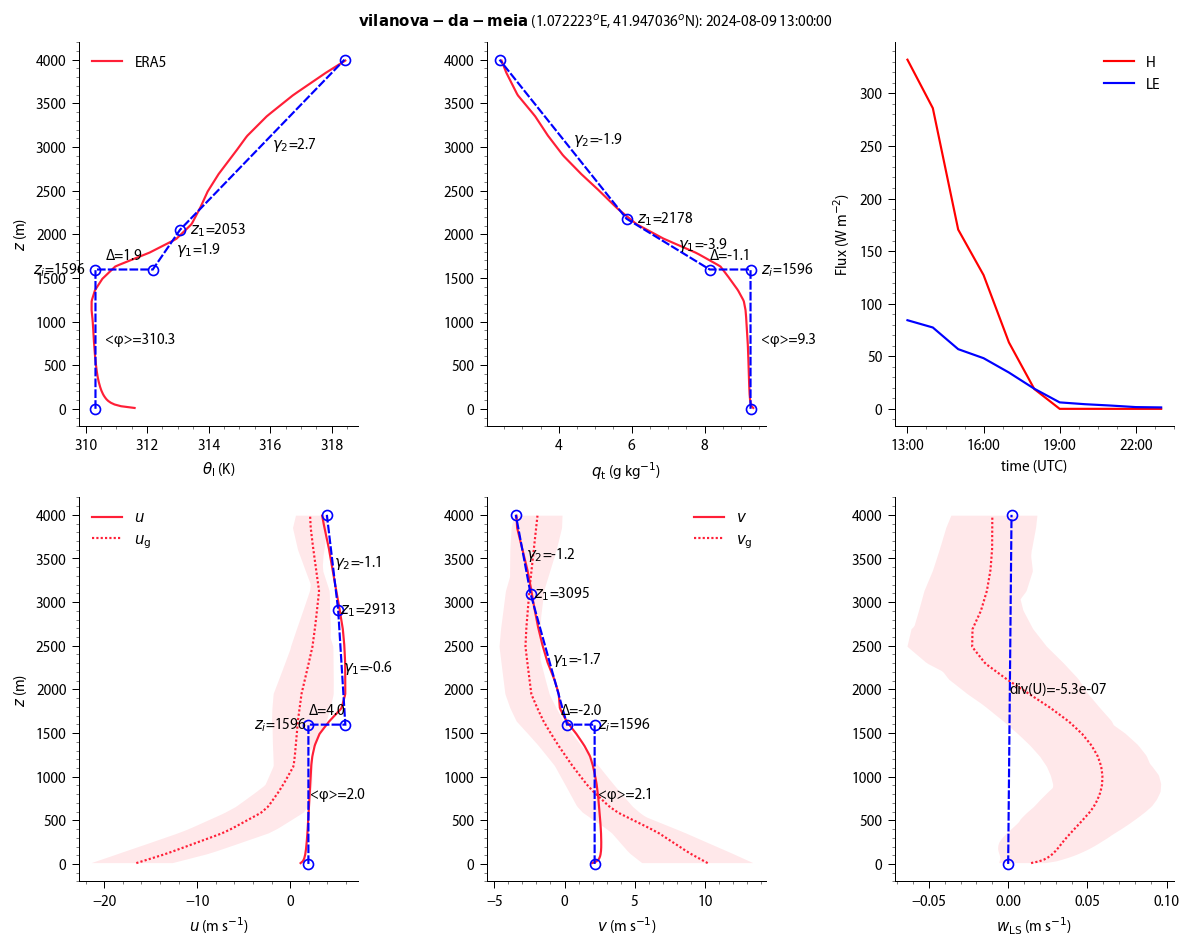

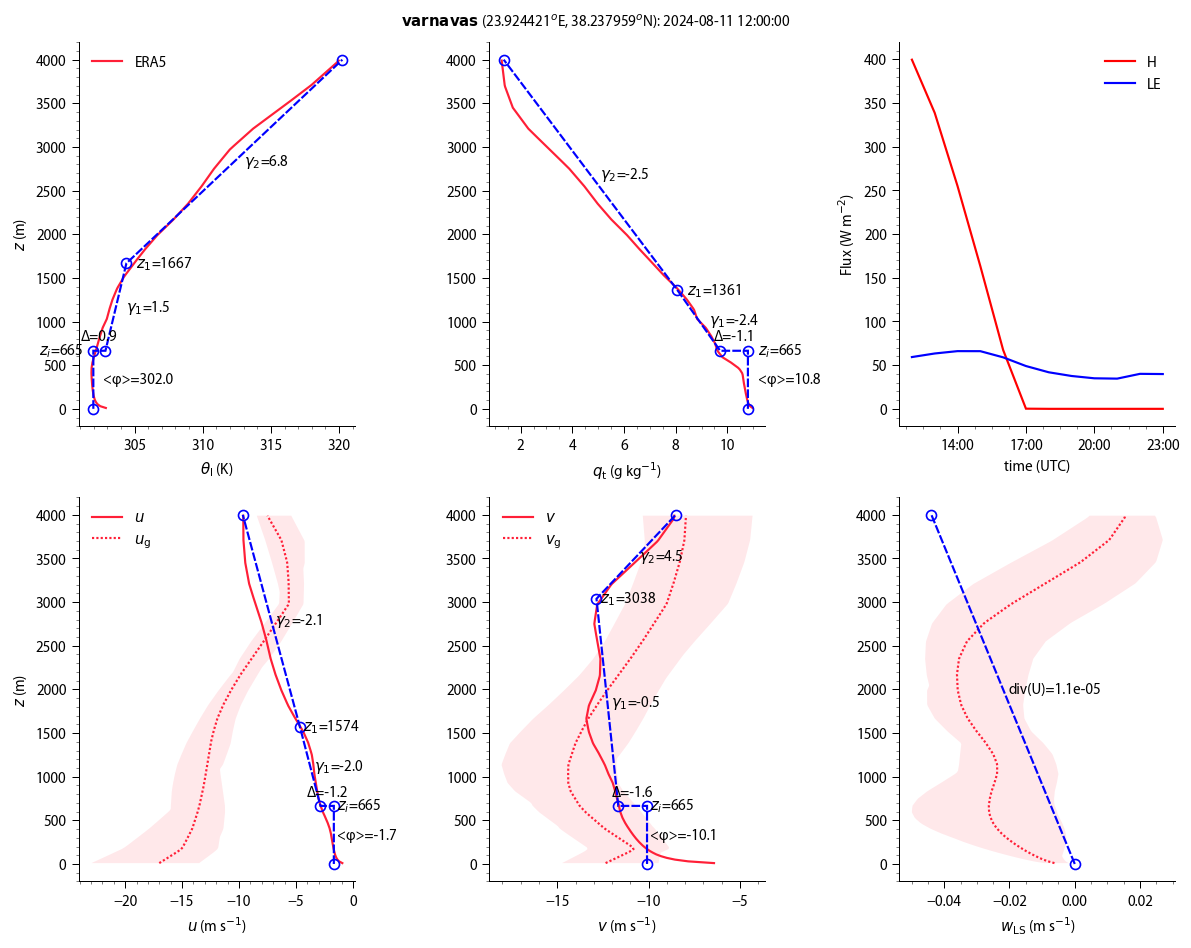

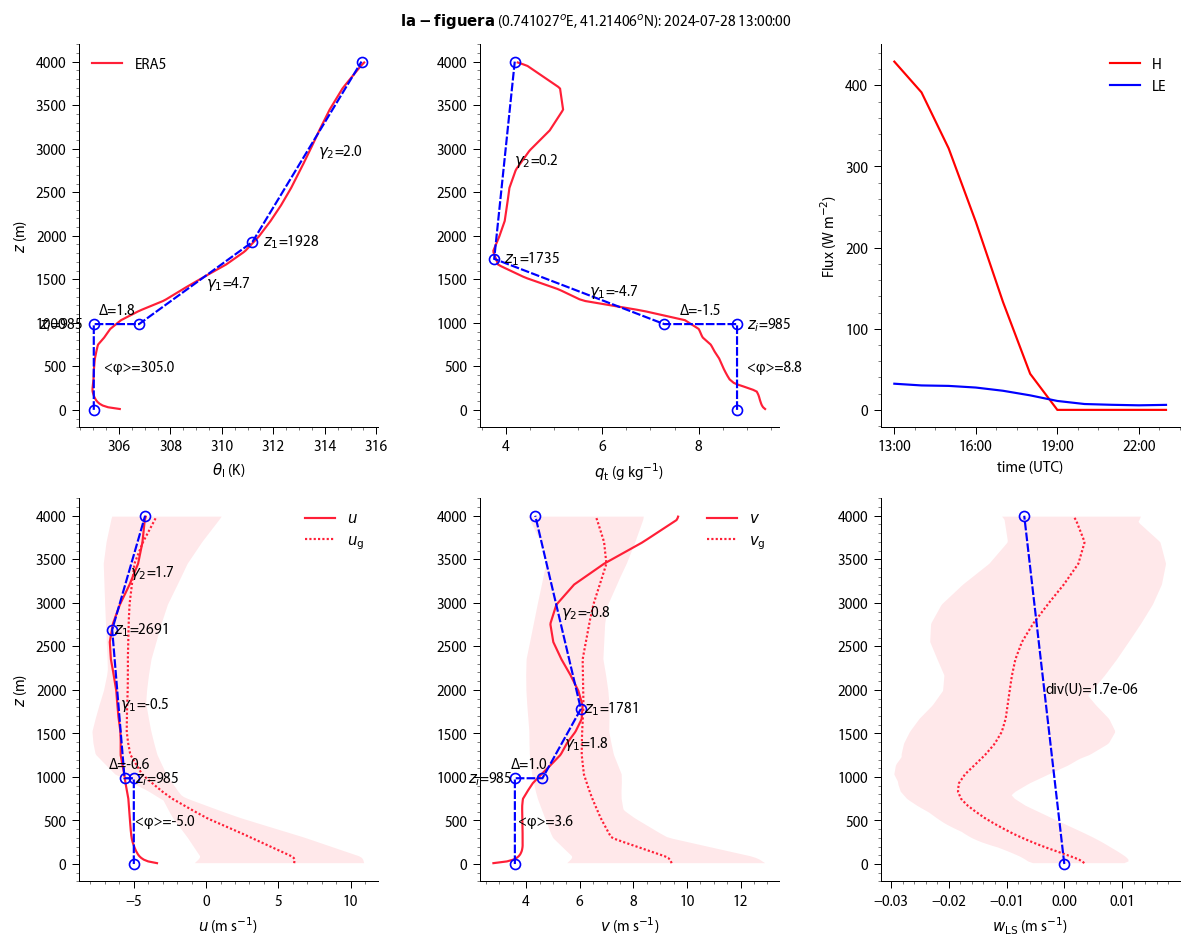

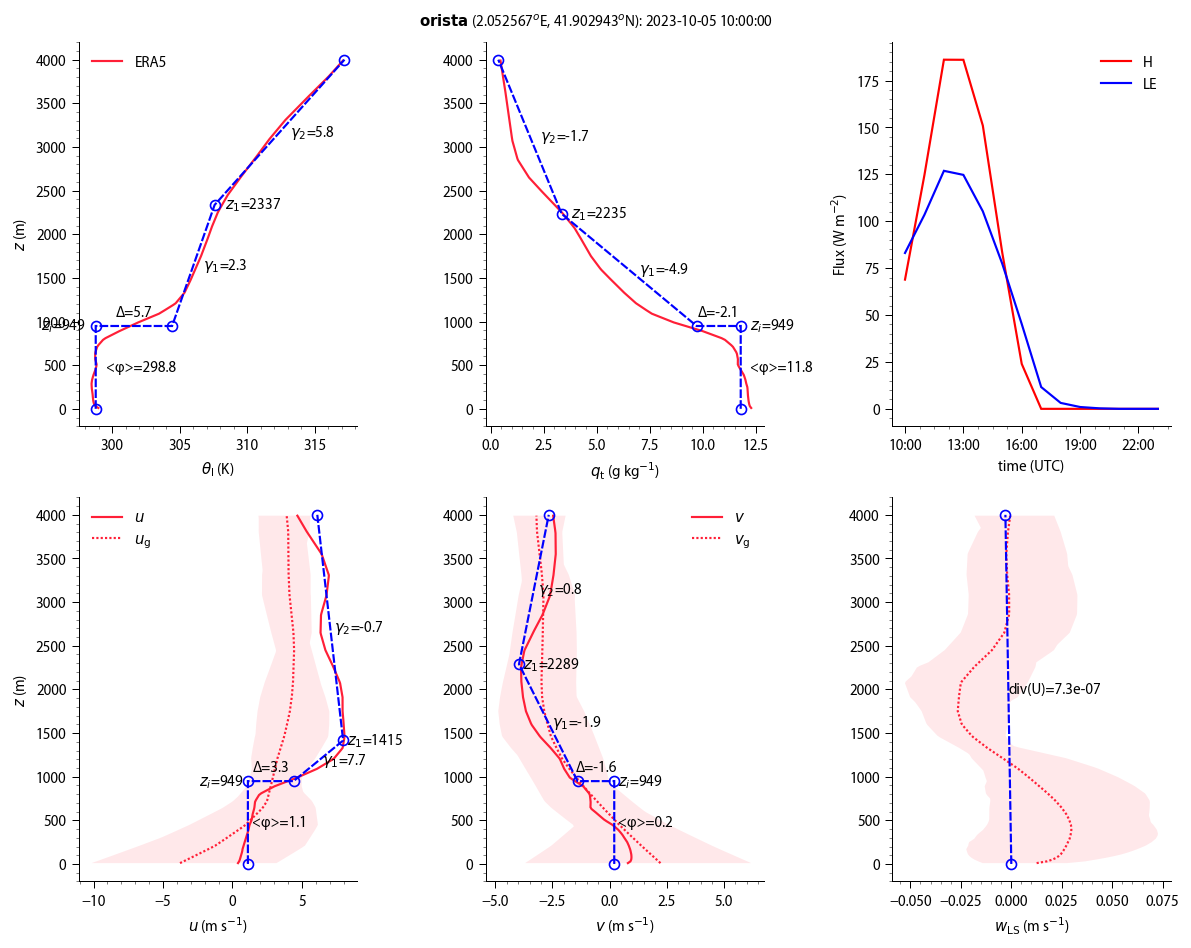

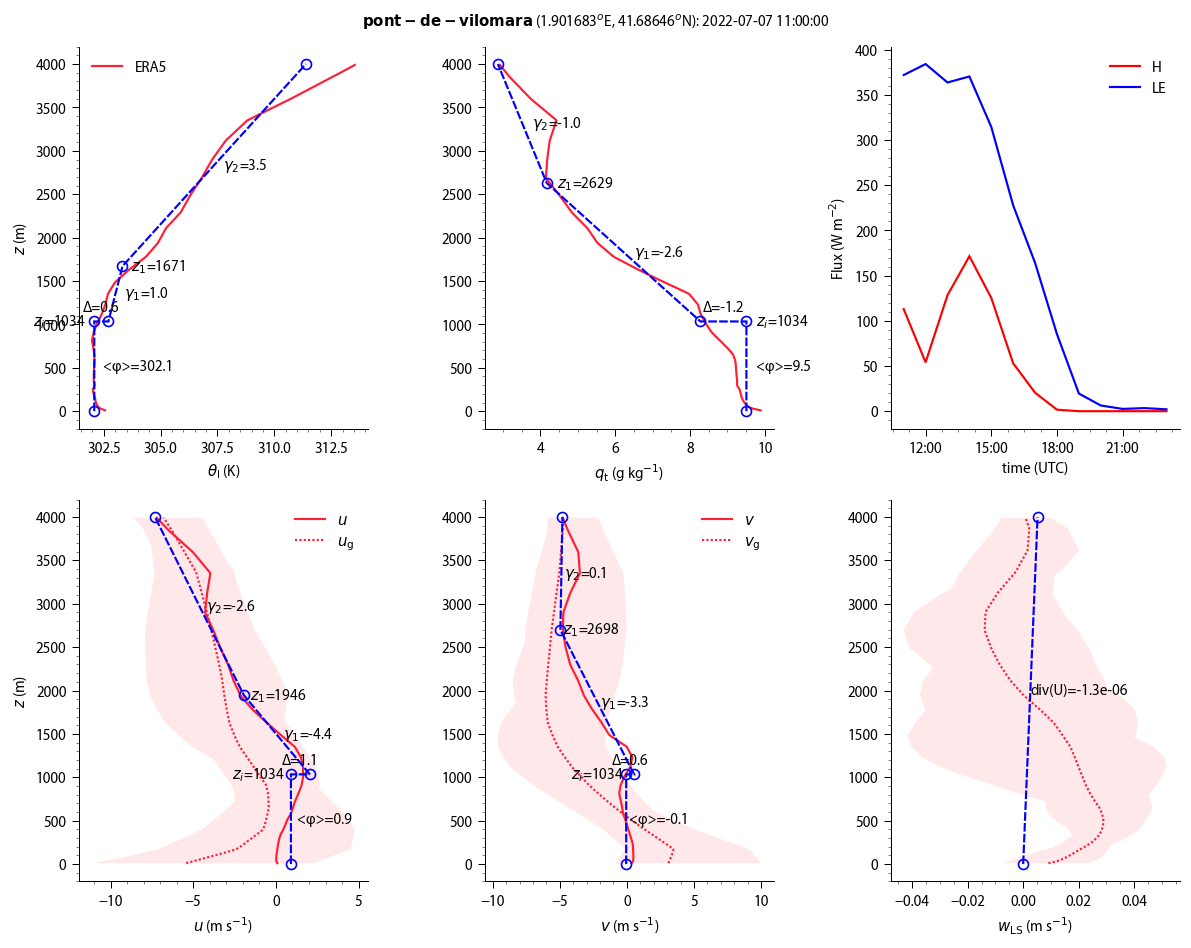

In [6]:
plt.close('all')

for name, case in cases.items():
    case.plot()

In [7]:
for name, case in cases.items():
    case.save_mxl_params()